# ОИАД. Лабораторная работа №4

**Цель:** построить несколько бинарных классификаторов для предсказания одного бинарного признака $y$ из набора признаков $X$ на датасете `../datasets/famcs_students.csv`.

**Модели:**
- Тривиальный классификатор (всегда предсказывает наиболее частый класс)
- Наивный байесовский классификатор (реализация вручную)
- k-ближайших соседей (реализация вручную, подбор k)
- Логистическая регрессия (реализация вручную, подбор порога по F1)

**Разбиение:** train 70% / val 15% / test 15%

**Метрики на тесте:** accuracy, precision, recall, roc-auc, матрица ошибок.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

N = 1

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target = binary_cols[N % 8]

print("Выбранная целевая переменная (y):", target)

path = "../datasets/famcs_students.csv"
try:
    df = pd.read_csv(path)
    print("Файл загружен:", path, "shape:", df.shape)
    display(df.head())
except FileNotFoundError:
    raise FileNotFoundError(
        f"Файл не найден по пути '{path}'. Убедитесь, что файл существует или поменяйте переменную 'path' на корректный путь."
    )


Выбранная целевая переменная (y): interest
Файл загружен: ../datasets/famcs_students.csv shape: (127, 25)


,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


### Предобработка данных — план

1. Приведём бинарные поля к 0/1 (Да/Нет -> 1/0).
2. Заполним пропуски: числовые — медианой, категориальные — модой.
3. Закодируем категориальные признаки вручную:
   - sex -> бинарно (М -> 1, иначе 0)
   - eye_color -> one-hot для топ-4 значений
   - sport -> frequency encoding
   - study_form -> бюджет/платно -> бинарно
4. Выберем не менее 5 признаков (см. код ниже).
5. Стандартизируем числовые признаки (по train) для k-NN и логрег.


In [74]:
df2 = df.copy()

drop_cols = ['cource','group','stream','work_experience','ai','social','miss','hostel']
for c in drop_cols:
    if c in df2.columns:
        df2 = df2.drop(columns=c)

def binarize_series(s):
    s = s.fillna('').astype(str).str.strip()
    yes = s.isin(['Да','Yes','да','YES','True','true','1','1.0'])
    no = s.isin(['Нет','No','нет','NO','False','false','0','0.0'])
    res = np.where(yes, 1, np.where(no, 0, np.nan))
    return pd.Series(res, index=s.index)

for b in binary_cols:
    if b in df2.columns:
        df2[b] = binarize_series(df2[b])

# Заполним пропуски: числовые медианой, остальные модой
for col in df2.columns:
    if df2[col].dtype.kind in 'biufc' or pd.api.types.is_numeric_dtype(df2[col]):
        col_numeric = pd.to_numeric(df2[col], errors='coerce')
        if col_numeric.notna().sum() == 0:
            df2[col] = 0
        else:
            df2[col] = col_numeric.fillna(col_numeric.median())


# кандидаты признаков
candidate_order = ['age','height','eye_color','sex','interest','weekend_study','sport','score','retake','anime','bad_sleep','glasses','literature','study_form']
features = [c for c in candidate_order if c in df2.columns and c != target]
features = features[:10]
print("Кандидаты признаков:", features)

df_proc = df2.copy()

# sex -> sex_m (М -> 1)
if 'sex' in df_proc.columns:
    df_proc['sex_m'] = df_proc['sex'].astype(str).str.startswith('М').astype(int)

# eye_color -> one-hot (топ 4)
if 'eye_color' in df_proc.columns:
    top_eye = df_proc['eye_color'].value_counts().index[:4]
    for t in top_eye:
        df_proc[f'eye_{t}'] = (df_proc['eye_color']==t).astype(int)

# sport -> frequency
if 'sport' in df_proc.columns:
    freq = df_proc['sport'].value_counts(normalize=True)
    df_proc['sport_freq'] = df_proc['sport'].map(freq).fillna(0.0)

# study_form -> budget flag
if 'study_form' in df_proc.columns:
    df_proc['study_budget'] = df_proc['study_form'].astype(str).str.contains('Бюджет').astype(int)

# ensure retake integer
if 'retake' in df_proc.columns:
    df_proc['retake'] = pd.to_numeric(df_proc['retake'], errors='coerce').fillna(0).astype(int)

# финальный список признаков
final_feats = []
candidates = ['age','height','sex_m','score','sport_freq','retake','study_budget']
# plus eye color top features if present
for c in df_proc.columns:
    if c.startswith('eye_'):
        candidates.append(c)
# plus binary columns that aren't target
for b in ['interest','weekend_study','anime','bad_sleep','glasses','literature']:
    if b in df_proc.columns and b != target:
        candidates.append(b)

for c in candidates:
    if c in df_proc.columns and c != target:
        final_feats.append(c)
    if len(final_feats) >= 7:
        break

print("Итоговые признаки:", final_feats)

df_proc[target] = pd.to_numeric(df_proc[target], errors='coerce')
df_proc = df_proc.dropna(subset=[target])
df_proc[target] = df_proc[target].astype(int)

X_all = df_proc[final_feats].astype(float).reset_index(drop=True)
y_all = df_proc[target].astype(int).reset_index(drop=True)
print("Размер готового набора:", X_all.shape)

# разбиение
rng = np.random.RandomState(42)
n = len(X_all)
perm = rng.permutation(n)
n_train = int(0.7*n)
n_val = int(0.15*n)
n_test = n - n_train - n_val
train_idx = perm[:n_train]
val_idx = perm[n_train:n_train+n_val]
test_idx = perm[n_train+n_val:]

X_train = X_all.iloc[train_idx].reset_index(drop=True)
y_train = y_all.iloc[train_idx].reset_index(drop=True)
X_val = X_all.iloc[val_idx].reset_index(drop=True)
y_val = y_all.iloc[val_idx].reset_index(drop=True)
X_test = X_all.iloc[test_idx].reset_index(drop=True)
y_test = y_all.iloc[test_idx].reset_index(drop=True)

print("Разбиение (train/val/test):", X_train.shape, X_val.shape, X_test.shape)


Кандидаты признаков: ['age', 'height', 'eye_color', 'sex', 'weekend_study', 'sport', 'score', 'retake', 'anime', 'bad_sleep']
Итоговые признаки: ['age', 'height', 'sex_m', 'score', 'sport_freq', 'retake', 'study_budget']
Размер готового набора: (127, 7)
Разбиение (train/val/test): (88, 7) (19, 7) (20, 7)


### 0. Тривиальный классификатор

Тривиальный (baseline) классификатор — это самая простая модель, которая **не использует признаки X**,  
а всегда выдаёт **один и тот же класс**.

Обычно берут класс, который встречается чаще всего в тренировочной выборке:

$$
\hat{y} = \arg\max_{c \in \{0,1\}} \; \text{Count}(y_{\text{train}} = c)
$$

То есть:

- если в тренировочных данных больше объектов класса **0**, модель всегда предсказывает **0**
- если больше класса **1**, она всегда выдаёт **1**

### Матрица ошибок для бинарной классификации

Матрица ошибок (confusion matrix):

$$
\begin{pmatrix}
TN & FP \\
FN & TP
\end{pmatrix}
$$

где:

- **TP** — True Positive  
- **TN** — True Negative  
- **FP** — False Positive  
- **FN** — False Negative  

### Accuracy

$$
\text{Accuracy} =
\frac{TP + TN}{TP + TN + FP + FN}
$$

### Precision

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Показывает, какая доля положительных предсказаний оказалась верной.

### Recall

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Показывает, какая доля объектов положительного класса была найдена.

### Roc-AUC  

ROC-AUC измеряет качество **ранжирования** модели, то есть то, насколько хорошо она  
отделяет один класс от другого.  
Если модель выдаёт прогнозы \( s_i \), то ROC-кривая строится как:

$$
\text{TPR}(t) = \frac{TP(t)}{TP(t) + FN(t)}
$$

$$
\text{FPR}(t) = \frac{FP(t)}{FP(t) + TN(t)}
$$

ROC-AUC:

$$
\text{AUC} = \int_0^1 \text{TPR}(\text{FPR}) \, d(\text{FPR})
$$

Для тривиального классификатора:

- если он всегда предсказывает один класс → нет ранжирования  
- AUC будет около **0.5**, иногда ниже/выше из-за дисбаланса классов


In [75]:
# Метрики и матрица ошибок (функции)
def confusion_matrix(y_true, y_pred):
    tp = int(((y_true==1) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    return np.array([[tn, fp],[fn, tp]])

def accuracy(y_true, y_pred):
    return float((y_true==y_pred).mean())

def precision(y_true, y_pred):
    tp = ((y_true==1) & (y_pred==1)).sum()
    fp = ((y_true==0) & (y_pred==1)).sum()
    return float(tp/(tp+fp)) if (tp+fp)>0 else 0.0

def recall(y_true, y_pred):
    tp = ((y_true==1) & (y_pred==1)).sum()
    fn = ((y_true==1) & (y_pred==0)).sum()
    return float(tp/(tp+fn)) if (tp+fn)>0 else 0.0

def roc_auc_from_scores(y_true, scores):
    desc_idx = np.argsort(-scores)
    y_sorted = np.array(y_true)[desc_idx]
    tps = np.cumsum(y_sorted==1)
    fps = np.cumsum(y_sorted==0)
    P = (y_true==1).sum()
    N = (y_true==0).sum()
    if P==0 or N==0:
        return 0.5
    tpr = np.concatenate([[0], tps/P, [1]])
    fpr = np.concatenate([[0], fps/N, [1]])
    auc = np.trapezoid(tpr, fpr)
    return float(auc)

# Тривиальный
mode = Counter(y_train).most_common(1)[0][0]
y_trivial_pred = np.full(len(y_test), fill_value=mode)
cm_trivial = confusion_matrix(y_test.values, y_trivial_pred)
metrics_trivial = {
    'accuracy': accuracy(y_test.values, y_trivial_pred),
    'precision': precision(y_test.values, y_trivial_pred),
    'recall': recall(y_test.values, y_trivial_pred),
    'roc_auc': roc_auc_from_scores(y_test.values, y_trivial_pred.astype(float))
}
print("Trivial metrics:", metrics_trivial)
print("Confusion matrix:\n", cm_trivial)


Trivial metrics: {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'roc_auc': 0.5}
Confusion matrix:
 [[20  0]
 [ 0  0]]


### Наивный байесовский классификатор (NB)

Модель основана на формуле:

$$
\hat{y}=\arg\max_{c\in\{0,1\}}
\left[
\log P(y=c) +
\sum_{j=1}^{n} \log P(x_j \mid y=c)
\right]
$$

#### 1. Априорные вероятности классов

$$
P(y=c)=\frac{\text{Count}(y=c)}{N}
$$

Используется в виде логарифма:

$$
\log P(y=c)
$$

#### 2. Вероятности признаков при классе

##### Если признак категориальный / бинарный

Используем частоты + сглаживание Лапласа:

$$
P(x_j=v \mid y=c)=
\frac{\text{Count}(x_j=v, y=c)+1}{\text{Count}(y=c)+K_j}
$$

где $K_j$ — число уникальных значений признака.

##### Если признак числовой (Гауссовский NB)

$$
P(x_j \mid y=c)=
\frac{1}{\sqrt{2\pi\sigma_{jc}^{2}}}
\exp\left(
-\frac{(x_j - \mu_{jc})^2}{2\sigma_{jc}^{2}}
\right)
$$

Используем логарифм:

$$
\log P(x_j \mid y=c)
=
-\frac{1}{2}\log(2\pi\sigma_{jc}^{2})
-\frac{(x_j - \mu_{jc})^2}{2\sigma_{jc}^{2}}
$$

#### 3. Итоговое решение

$$
\text{score}(c) =
\log P(y=c) +
\sum_{j} \log P(x_j \mid y=c)
$$

$$
\hat{y} = \arg\max_c \text{score}(c)
$$



In [76]:
# Naive Bayes
class MixedNaiveBayes:
    def __init__(self, feature_types):
        self.feature_types = feature_types
        self.class_prior = {}
        self.params = {}
        self.classes_ = None

    def fit(self, X, y):
        X = X.copy().reset_index(drop=True)
        y = np.array(y)
        self.classes_ = np.unique(y)
        for c in self.classes_:
            Xc = X[y==c]
            self.class_prior[c] = (len(Xc)+1) / (len(y)+len(self.classes_))
            self.params[c] = {}
            for feat, ftype in self.feature_types.items():
                col = Xc[feat].astype(float)
                if ftype=='continuous':
                    mu = col.mean()
                    var = col.var(ddof=0) + 1e-6
                    self.params[c][feat] = ('gauss', mu, var)
                else:
                    p = (col.sum()+1) / (len(col)+2)
                    self.params[c][feat] = ('bern', p)

    def _log_likelihood(self, x):
        res = {}
        for c in self.classes_:
            logp = np.log(self.class_prior[c])
            for feat, ftype in self.feature_types.items():
                val = float(x[feat])
                typ = self.params[c][feat][0]
                if typ=='gauss':
                    mu = self.params[c][feat][1]
                    var = self.params[c][feat][2]
                    ll = -0.5*np.log(2*np.pi*var) - ((val-mu)**2)/(2*var)
                    logp += ll
                else:
                    p = self.params[c][feat][1]
                    ll = np.log(p) if val==1 else np.log(1-p)
                    logp += ll
            res[c] = logp
        return res

    def predict_proba(self, X):
        X = X.reset_index(drop=True)
        probs = []
        for i in range(len(X)):
            logs = self._log_likelihood(X.loc[i])
            vals = np.array(list(logs.values()))
            mx = vals.max()
            ex = np.exp(vals - mx)
            probs_i = ex / ex.sum()
            probs.append([probs_i[list(logs.keys()).index(c)] for c in self.classes_])
        return np.array(probs)

    def predict(self, X):
        proba = self.predict_proba(X)
        class_idx = proba.argmax(axis=1)
        return self.classes_[class_idx]

# Определим типы признаков: бинарные vs непрерывные
feature_types = {}
binary_like = {'interest','weekend_study','anime','bad_sleep','glasses','literature','sex_m','study_budget','retake'}
for f in final_feats:
    feature_types[f] = 'binary' if f in binary_like else 'continuous'

nb = MixedNaiveBayes(feature_types)
nb.fit(X_train[final_feats], y_train)
nb_probs_test = nb.predict_proba(X_test[final_feats])
if 1 in nb.classes_:
    idx1 = list(nb.classes_).index(1)
    nb_scores_test = nb_probs_test[:, idx1]
else:
    nb_scores_test = np.zeros(len(X_test))
nb_preds_test = (nb_scores_test >= 0.5).astype(int)

cm_nb = confusion_matrix(y_test.values, nb_preds_test)
metrics_nb = {
    'accuracy': accuracy(y_test.values, nb_preds_test),
    'precision': precision(y_test.values, nb_preds_test),
    'recall': recall(y_test.values, nb_preds_test),
    'roc_auc': roc_auc_from_scores(y_test.values, nb_scores_test)
}
print("Naive Bayes metrics:", metrics_nb)
print("Confusion matrix:\n", cm_nb)


Naive Bayes metrics: {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'roc_auc': 0.5}
Confusion matrix:
 [[20  0]
 [ 0  0]]


### Метод k-ближайших соседей (k-NN)

k-NN — некparamетрический метод классификации, который не обучает модель, а хранит обучающие данные и принимает решение по ближайшим соседям.


## 1. Расстояние между объектами

Чаще всего используется евклидово расстояние:

$$
d(x, x_i) = \sqrt{\sum_{j=1}^{n}(x_j - x_{ij})^2}
$$

В коде обычно берут квадрат расстояния (без корня), так как:

$$
\sqrt{\cdot} \ \text{не влияет на порядок расстояний.}
$$

## 2. Поиск k ближайших соседей

Берём k объектов с наименьшими расстояниями:

$$
\text{Neighbors}(x) = \operatorname{arg\,topk}_{i}( -d(x, x_i) )
$$

## 3. Голосование (majority vote)

Предсказание — класс, встречающийся чаще среди соседей:

$$
\hat{y} =
\operatorname{mode}\left( y_{(1)}, y_{(2)}, \ldots, y_{(k)} \right)
$$

где $y_{(i)}$ — класс i-го ближайшего соседа.

## 4. Взвешенное голосование

Иногда соседи взвешиваются обратно расстоянию:

$$
w_i = \frac{1}{d(x, x_i) + \varepsilon}
$$

$$
\hat{y} = \arg\max_{c}
\sum_{i \in \text{Neighbors}}
w_i \cdot \mathbf{1}[y_i = c]
$$

k-NN не строит явную модель — решение принимается только на основе соседей.


In [77]:
# стандартизация по train
mean = X_train.mean()
std = X_train.std(ddof=0).replace(0,1.0)
def standardize(X):
    return (X - mean)/std

X_train_s = standardize(X_train)
X_val_s = standardize(X_val)
X_test_s = standardize(X_test)

def knn_predict(X_train, y_train, X_query, k=3):
    X_train_np = X_train.values
    Xq = X_query.values
    preds = []
    scores = []
    for i in range(len(Xq)):
        dists = np.sqrt(((X_train_np - Xq[i])**2).sum(axis=1))
        nn_idx = np.argsort(dists)[:k]
        votes = y_train.values[nn_idx]
        prob = votes.mean()
        pred = 1 if prob>=0.5 else 0
        preds.append(pred)
        scores.append(prob)
    return np.array(preds), np.array(scores)

# подбор k
ks = list(range(1,26,2))
best_k = None
best_f1 = -1.0

def f1(p,r):
    return 2*p*r/(p+r) if (p+r)>0 else 0.0

for k in ks:
    preds_val, _ = knn_predict(X_train_s, y_train, X_val_s, k=k)
    p = precision(y_val.values, preds_val)
    r = recall(y_val.values, preds_val)
    f = f1(p,r)
    if f > best_f1:
        best_f1 = f
        best_k = k
print("Лучший k на валидации:", best_k, "F1:", best_f1)

# оценка на тесте
knn_preds_test, knn_scores_test = knn_predict(X_train_s, y_train, X_test_s, k=best_k)
cm_knn = confusion_matrix(y_test.values, knn_preds_test)
metrics_knn = {
    'accuracy': accuracy(y_test.values, knn_preds_test),
    'precision': precision(y_test.values, knn_preds_test),
    'recall': recall(y_test.values, knn_preds_test),
    'roc_auc': roc_auc_from_scores(y_test.values, knn_scores_test)
}
print("k-NN metrics:", metrics_knn)
print("Confusion matrix:\n", cm_knn)


Лучший k на валидации: 1 F1: 0.0
k-NN metrics: {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'roc_auc': 0.5}
Confusion matrix:
 [[20  0]
 [ 0  0]]


### Логистическая регрессия

Модель оценивает вероятность класса 1:

$$
\hat{p}(y=1 \mid x) = \sigma(w^\top x + b)
$$

где сигмоида:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

## 1. Решение модели

Ищем параметры $w, b$, минимизируя логистическую (кросс-энтропийную) потерю:

$$
L = - \frac{1}{N}
\sum_{i=1}^{N}
\left[
y_i \log \hat{p}_i + (1-y_i)\log(1-\hat{p}_i)
\right]
$$

## 2. Регуляризация

L2-регуляризация:

$$
L_{reg} = L + \lambda \|w\|^2
$$

Она стабилизирует модель и предотвращает переобучение.

## 3. Предсказание класса

$$
\hat{y} =
\begin{cases}
1, & \hat{p} \ge 0.5 \\
0, & \hat{p} < 0.5
\end{cases}
$$

## в коде

1. Считается линейная комбинация признаков:  
   $$
   z = w^\top x + b
   $$
2. Применяется сигмоида — получаем вероятность.
3. Вероятность → класс по порогу 0.5.
4. Метрики (accuracy, precision, recall, ROC AUC) считаются так же, как для других моделей.


Лучший порог по F1 (валидация): 0.0 F1: 0.0


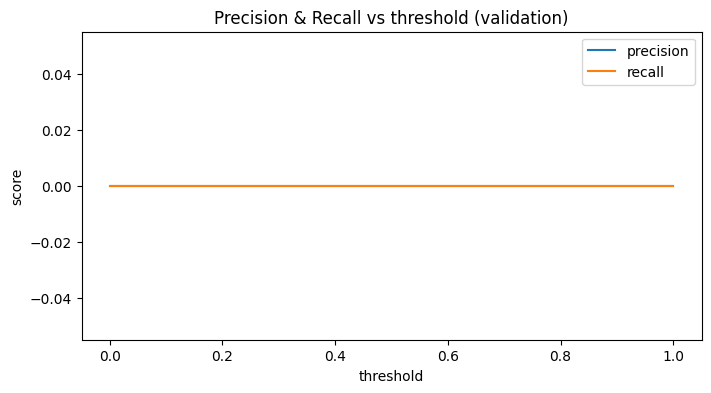

Logistic Regression metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'roc_auc': 0.5}
Confusion matrix:
 [[ 0 20]
 [ 0  0]]


In [78]:
# Логистическая регрессия (градиентный спуск)
class LogisticRegressionGD:
    def __init__(self, lr=0.1, n_iter=1000, C=1.0, fit_intercept=True, verbose=False):
        self.lr = lr
        self.n_iter = n_iter
        self.C = C
        self.fit_intercept = fit_intercept
        self.verbose = verbose

    def _add_intercept(self, X):
        if self.fit_intercept:
            return np.hstack([np.ones((X.shape[0],1)), X])
        return X

    def fit(self, X, y):
        Xn = X if isinstance(X, np.ndarray) else X.values
        Xn = Xn.astype(float)
        Xn = self._add_intercept(Xn)
        n_samples, n_features = Xn.shape
        self.w = np.zeros(n_features)
        y = y.astype(float)
        for it in range(self.n_iter):
            z = Xn.dot(self.w)
            preds = 1/(1+np.exp(-z))
            grad = (Xn.T.dot(preds - y))/n_samples + (1.0/self.C)*self.w
            if self.fit_intercept:
                grad[0] -= (1.0/self.C)*self.w[0]
            self.w -= self.lr * grad
        return self

    def predict_proba(self, X):
        Xn = X if isinstance(X, np.ndarray) else X.values
        Xn = Xn.astype(float)
        Xn = self._add_intercept(Xn)
        z = Xn.dot(self.w)
        preds = 1/(1+np.exp(-z))
        return preds

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Стандартизованные данные
X_train_lr = standardize(X_train)
X_val_lr = standardize(X_val)
X_test_lr = standardize(X_test)

# Обучение
lr = LogisticRegressionGD(lr=0.5, n_iter=2000, C=1.0)
lr.fit(X_train_lr.values, y_train.values)

# Вероятности на валидации -> подбор порога
val_probs = lr.predict_proba(X_val_lr.values)
thresholds = np.linspace(0,1,101)
precisions = []
recalls = []
f1s = []
for t in thresholds:
    preds = (val_probs >= t).astype(int)
    p = precision(y_val.values, preds)
    r = recall(y_val.values, preds)
    f = f1(p,r)
    precisions.append(p); recalls.append(r); f1s.append(f)

best_idx = int(np.argmax(f1s))
best_threshold = thresholds[best_idx]
print("Лучший порог по F1 (валидация):", best_threshold, "F1:", f1s[best_idx])

# График precision & recall от порога
plt.figure(figsize=(8,4))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.xlabel("threshold")
plt.ylabel("score")
plt.legend()
plt.title("Precision & Recall vs threshold (validation)")
plt.show()

# Оценка на тесте
test_probs_lr = lr.predict_proba(X_test_lr.values)
lr_preds_test = (test_probs_lr >= best_threshold).astype(int)
cm_lr = confusion_matrix(y_test.values, lr_preds_test)
metrics_lr = {
    'accuracy': accuracy(y_test.values, lr_preds_test),
    'precision': precision(y_test.values, lr_preds_test),
    'recall': recall(y_test.values, lr_preds_test),
    'roc_auc': roc_auc_from_scores(y_test.values, test_probs_lr)
}
print("Logistic Regression metrics:", metrics_lr)
print("Confusion matrix:\n", cm_lr)


### 4. Итог: сравнение моделей на тестовой выборке

Выведите сводную таблицу с метриками (accuracy, precision, recall, roc-auc) и матрицами ошибок для всех моделей: Trivial, NaiveBayes, k-NN, LogisticRegression.


,model,accuracy,precision,recall,roc_auc,confusion
0,Trivial,1.0,0.0,0.0,0.5,"[[20, 0], [0, 0]]"
1,NaiveBayes,1.0,0.0,0.0,0.5,"[[20, 0], [0, 0]]"
2,k-NN (k=1),1.0,0.0,0.0,0.5,"[[20, 0], [0, 0]]"
3,LogisticRegression,0.0,0.0,0.0,0.5,"[[0, 20], [0, 0]]"


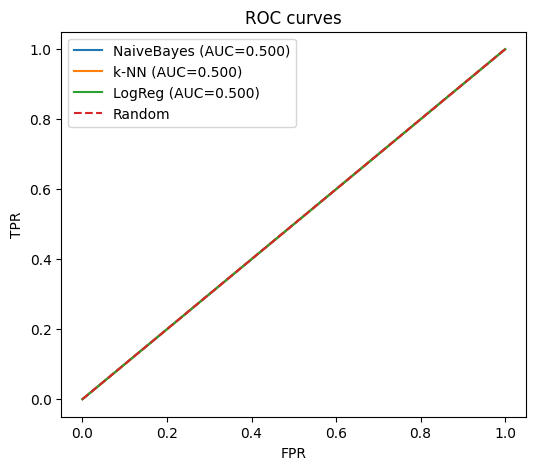

In [79]:
rows = []
for name, met, cm in [
    ('Trivial', metrics_trivial, cm_trivial),
    ('NaiveBayes', metrics_nb, cm_nb),
    (f'k-NN (k={best_k})', metrics_knn, cm_knn),
    ('LogisticRegression', metrics_lr, cm_lr)
]:
    rows.append({
        'model': name,
        'accuracy': met['accuracy'],
        'precision': met['precision'],
        'recall': met['recall'],
        'roc_auc': met['roc_auc'],
        'confusion': cm.tolist()
    })
res_df = pd.DataFrame(rows)
display(res_df)

# ROC plotting helper
def roc_points(y_true, scores):
    desc_idx = np.argsort(-scores)
    y_sorted = np.array(y_true)[desc_idx]
    tps = np.cumsum(y_sorted==1)
    fps = np.cumsum(y_sorted==0)
    P = (y_true==1).sum()
    N = (y_true==0).sum()
    if P==0 or N==0:
        return np.array([0,1]), np.array([0,1])
    tpr = np.concatenate([[0], tps/P, [1]])
    fpr = np.concatenate([[0], fps/N, [1]])
    return fpr, tpr

plt.figure(figsize=(6,5))
# NB
fpr_nb, tpr_nb = roc_points(y_test.values, nb_scores_test)
plt.plot(fpr_nb, tpr_nb, label='NaiveBayes (AUC={:.3f})'.format(metrics_nb['roc_auc']))
# kNN
fpr_knn, tpr_knn = roc_points(y_test.values, knn_scores_test)
plt.plot(fpr_knn, tpr_knn, label='k-NN (AUC={:.3f})'.format(metrics_knn['roc_auc']))
# LR
fpr_lr, tpr_lr = roc_points(y_test.values, test_probs_lr)
plt.plot(fpr_lr, tpr_lr, label='LogReg (AUC={:.3f})'.format(metrics_lr['roc_auc']))
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("ROC curves")
plt.show()
